## In-class hands-on activity: Feature Selection

### Heart Failure Prediction
Original dataset from <https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data>

走過下面的的Cell, 依序執行。下面有些Cell中標明"TODO"。請依照說明完成這些函數或程式片段，讓整個檔案能正確的執行。



feature selection
https://scikit-learn.org/stable/api/sklearn.feature_selection.html


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

%matplotlib inline

pd.set_option('display.max_column', 500)
pd.set_option('display.max_rows', 5000)


### 資料說明 (From the original data provider)

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

### Attribute Information
* Age: age of the patient [years]
* Sex: sex of the patient [M: Male, F: Female]
* ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP: resting blood pressure [mm Hg]
* Cholesterol: serum cholesterol [mm/dl]
* FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
* Oldpeak: oldpeak = ST [Numeric value measured in depression]
* ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease: output class [1: heart disease, 0: Normal]


In [2]:
# Start with data loading and showing sample data
df=pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# make sure the data types are reasonable
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [4]:
df.HeartDisease.value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [5]:
cat_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df_wc=pd.get_dummies(df,columns=cat_cols, drop_first=False)
df_wc.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,True,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,False,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,True,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,False,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,False,True,False,False,True,False,True,False,False,False,True


In [6]:
# split training and test

random.seed(1001)
np.random.seed(1001)
mask1 = np.random.rand(len(df_wc)) < 0.9
df_wc_train = df_wc[mask1].copy()
df_wc_test = df_wc[~mask1].copy()

target = 'HeartDisease'
featnames = df_wc.columns.to_list()
featnames.remove(target)

print("Features to be include in the model", featnames)

Features to be include in the model ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


In [7]:
# Feature standardization

X_train = df_wc_train[featnames].values
y_train = df_wc_train[target].values

X_test = df_wc_test[featnames].values
y_test = df_wc_test[target].values

mm_scaler=preprocessing.MinMaxScaler()
X_train=mm_scaler.fit_transform(X_train)
X_test=mm_scaler.transform(X_test)


### Fitting Logistic Regression

Use linear_model.LogisticRegressionCV() to fit a logistic regression model to the training data. Use metrics.classification_report() to compute prediction performance. Answer the following questions. 

1. List first five coefficients and their feature names.
2. Interpret the meanings of these feature coefficients.
3. Show the regularization coefficient selected by the CV routine.
4. Apply the model to predict the test set. What is the accuracy, precision, and recall?

In [8]:
# Fitting Logistic Regression
from sklearn.linear_model import LogisticRegressionCV

logreg_cv = LogisticRegressionCV(cv=5, penalty='l2', solver='lbfgs', max_iter=1000, scoring='accuracy', random_state=1001)
logreg_cv.fit(X_train, y_train)

coefs = logreg_cv.coef_[0]
for i in range(5):
    print(f"{featnames[i]:<15}: {coefs[i]:.4f}")

y_pred = logreg_cv.predict(X_test)
print("\nClassification report on test set:")
print(metrics.classification_report(y_test, y_pred, digits=4))

print(f"\nRegularization coefficient (C) selected by CV: {logreg_cv.C_[0]:.4f}")

Age            : 0.0811
RestingBP      : 0.0103
Cholesterol    : -0.0796
FastingBS      : 0.1846
MaxHR          : -0.0993

Classification report on test set:
              precision    recall  f1-score   support

           0     0.9286    0.7647    0.8387        34
           1     0.8222    0.9487    0.8810        39

    accuracy                         0.8630        73
   macro avg     0.8754    0.8567    0.8598        73
weighted avg     0.8718    0.8630    0.8613        73


Regularization coefficient (C) selected by CV: 0.0060


正值表示該特徵增加時，患心臟病的機率增加；負值則相反。

### Sanity Check
<pre>
First five features and coefficients
Age         : 0.0811
RestingBP   : 0.0103
Cholesterol : -0.0796
FastingBS   : 0.1846
MaxHR       : -0.0993
---
The regularization coefficient is 0.0060
---
              precision    recall  f1-score   support

           0     0.9286    0.7647    0.8387        34
           1     0.8222    0.9487    0.8810        39

    accuracy                         0.8630        73
   macro avg     0.8754    0.8567    0.8598        73
weighted avg     0.8718    0.8630    0.8613        73    
</pre>

### Feature Selection Exercise: Using Chi-Squared Scores

Refer to the document if neede: 
<https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2>

We will not touch the continuous features (index 0 - 5) in this part and will focus on discrete features. Below list all discrete features considered. 


In [9]:
catnames = featnames[6:]
print(f"One-hot encoded features: {catnames}")

One-hot encoded features: ['Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


### TODO

Identify and remove four one-hot encoded features that are the least useful based on the Chi-squared scores. Rerun the logistic regression and observe the changes in accuracy F1-score. Compute the chi-squared score using `sklearn.feature_selection.chi2()` directly and then follow through the feature selection routine. The goal of this exercise is to get familiar with the univariate feature selection procedure. Do not use automated routine such as `sklearn.feature_selection.SelectKBest.`  Use these wonderful routines sometime later when you know exactly what you are doing. 

In addition to the change in prediction performance, pay special attention to Sex_F and Sex_M. What happened to these two features and why?



In [10]:
# Feature Selection by Chi-squared scores
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X_cat_train = df_wc_train[catnames]
chi2_scores, _ = chi2(X_cat_train, y_train)
chi2_result = pd.Series(chi2_scores, index=catnames).sort_values()

remove_features = chi2_result.index[:4].tolist()
for f in remove_features:
        print("Removing", f)

new_featnames = [f for f in featnames if f not in remove_features]

X_train_new = df_wc_train[new_featnames].values
X_test_new = df_wc_test[new_featnames].values
mm_scaler_new = MinMaxScaler()
X_train_new = mm_scaler_new.fit_transform(X_train_new)
X_test_new = mm_scaler_new.transform(X_test_new)

logreg_cv2 = LogisticRegressionCV(cv=5, penalty='l2', solver='lbfgs', max_iter=1000, scoring='accuracy', random_state=1001)
logreg_cv2.fit(X_train_new, y_train)
y_pred_new = logreg_cv2.predict(X_test_new)
print("\nClassification report after feature removal:")
print(metrics.classification_report(y_test, y_pred_new, digits=4))

print("\nSex_F and Sex_M still in features?" , "Sex_F" in new_featnames, ",", "Sex_M" in new_featnames)

Removing RestingECG_LVH
Removing ChestPainType_TA
Removing RestingECG_Normal
Removing RestingECG_ST

Classification report after feature removal:
              precision    recall  f1-score   support

           0     0.9310    0.7941    0.8571        34
           1     0.8409    0.9487    0.8916        39

    accuracy                         0.8767        73
   macro avg     0.8860    0.8714    0.8744        73
weighted avg     0.8829    0.8767    0.8755        73


Sex_F and Sex_M still in features? True , True


Sex_F、Sex_M 這兩個特徵在資料中很可能與目標變數 y 有顯著關聯，所以在計算 chi2 時分數很高。

### Sanity Check
<pre>
Removing RestingECG_LVH
Removing ChestPainType_TA
Removing RestingECG_Normal
Removing RestingECG_ST    
</pre>

### --- Remove below ---

When using all features:
* accuracy =  0.8630
* F1-score = 0.8810

When removed 4 least useful features using Chi-squared scores:
* accuracy = 0.8767
* F1-score = 0.8916

It seems that feature selection do help with model prediction performance!

### --- remove above ---

### The Wrapper Approach Using RFECV

The Recursive Feature Elimination with Cross Validation (RFECV) implements a version of backward feature selection that we have discussed in class. Below is the description from the document:

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute (such as coef_, feature_importances_) or callable. Then, the least important features are pruned from the current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFECV performs RFE in a cross-validation loop to find the optimal number of features. 

Refer to the document if neede: <https://scikit-learn.org/stable/modules/feature_selection.html#rfe>

Please use RFECV to select the best subset of features using `LogisticRegression(C=10)`as the estimator. Set the min_features_to_select to 1 and use accuracy for scoring. Create a sklearn.model_selection.StratifiedKFold(5) to provide cross validation functionality. 

Report the number of optimal features select, list these features, and report prediction performance. Note that we are considering all features no matter they are discrete or continuously valued. 

In [11]:
# Wrapper Approach Using RFECV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

estimator = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=1000, random_state=1001)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1001)
rfecv = RFECV(estimator, step=1, cv=cv, scoring='accuracy', min_features_to_select=1)
rfecv.fit(X_train, y_train)

print("Optimal number of features:", rfecv.n_features_)

selected_features = [feat for feat, selected in zip(featnames, rfecv.support_) if selected]
print("Selected features are", selected_features)

X_train_rfecv = X_train[:, rfecv.support_]
X_test_rfecv = X_test[:, rfecv.support_]

final_model = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=1000, random_state=1001)
final_model.fit(X_train_rfecv, y_train)
y_pred_rfecv = final_model.predict(X_test_rfecv)

print("Classification report with selected features:")
print(metrics.classification_report(y_test, y_pred_rfecv, digits=4))

Optimal number of features: 13
Selected features are ['Age', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ExerciseAngina_N', 'ST_Slope_Flat', 'ST_Slope_Up']
Classification report with selected features:
              precision    recall  f1-score   support

           0     0.9355    0.8529    0.8923        34
           1     0.8810    0.9487    0.9136        39

    accuracy                         0.9041        73
   macro avg     0.9082    0.9008    0.9029        73
weighted avg     0.9064    0.9041    0.9037        73



### Sanity Check

<pre>
Optimal number of features: 13
Selected features are ['Age', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ExerciseAngina_N', 'ST_Slope_Flat', 'ST_Slope_Up']    
</pre>


### Prediction Accuracy vs. Number of Features

For the last part, let's look at the plot of the prediction accuracy on the number of features included. 

TODO: Can you compute the number of features to be include using the one-standard-deviation rule?

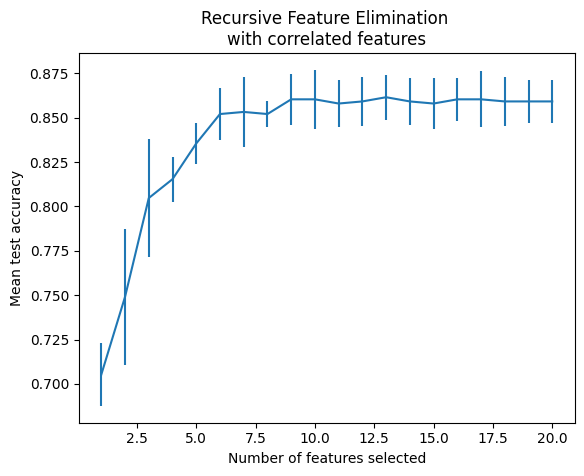

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### TODO

Compute the number of features to be included using the one-standard-deviation rule. 



In [13]:
# One-standard-deviation rule for RFECV
import numpy as np

mean_scores = rfecv.cv_results_["mean_test_score"]
std_scores = rfecv.cv_results_["std_test_score"]
n_features = rfecv.cv_results_["n_features"]

max_acc_idx = np.argmax(mean_scores)
print("Number of features that maximize accuracy =", n_features[max_acc_idx])

lower_bound = mean_scores[max_acc_idx] - std_scores[max_acc_idx]

n_features_1sd = n_features[np.where(mean_scores >= lower_bound)[0][0]]
print("Number of features that achieve the lower bound accuracy =", n_features_1sd)

Number of features that maximize accuracy = 13
Number of features that achieve the lower bound accuracy = 6


### Sanity Check

<pre>
Number of features that maximize accuracy = 14
Number of features that achieve the lower bound accuracy = 5    
</pre>